In [1]:
import numpy as np
import pandas as pd
from glob import glob
import datetime
from pyproj import Transformer
import matplotlib.pyplot as plt
import wradlib as wrl
import re

In [3]:
# raw = wrl.io.read_generic_hdf5('C:/Users/sverrirhd/vedurgogn/radar/2020/202001/2020010100050000dBZ.vol.hdf5') # 2020 01 01 00 05
# az_angle_bins = np.array([[float(j) for j in (i.split(':'))] for i in raw['dataset1/how']['attrs']['azangles'].decode().split(',')])
# attributes = raw['dataset1/data1/what']['attrs']
# gain = attributes['gain']
# offset = attributes['offset']

In [4]:
# For working with coordinates
transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

# URLS
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
URL_gauge_2020_file = URL_gauge_data + 'clean2020data1475.csv'
URL_saved_sensor_data = URL_gauge_data + 'hbs_lysigogn.csv'
DIR_rain_gauges = glob(URL_gauge_data + '*cleaned*')

DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
URL_dates = glob(DIR_data + '??_file_dates.npy')
URL_missing_indexes = glob(DIR_data + '??_missing_indexes.npy')
URL_pixel_coords_save = DIR_data + 'radar_pixel_coords.npy'

def get_dates(URL):
    dates = np.load(URL,allow_pickle=True)
    return dates

def get_missing(URL):
    missing_indexes = np.load(URL)
    return missing_indexes

def to_rainfall(radar_data):
    return wrl.zr.z_to_r(wrl.trafo.idecibel(offset + gain * radar_data), a=200, b=1.6)

In [12]:

DIR_CAPPI = 'C:/Users/sverrirhd/OneDrive/CAPPI/'

urls_cappi = glob(DIR_CAPPI + 'CAPPI*')
urls_descr = glob(DIR_CAPPI + 'descriptive_data*')
urls_probl = glob(DIR_CAPPI + 'problematic_indexes*')
urls_urls = glob(DIR_CAPPI + 'urls*')


In [4]:
# runtime approx 60sec
from scipy.sparse import load_npz,save_npz

radar_csc = load_npz(DIR_data + 'radar_2020_sparse_csc_matrix.npz')

first_layer = radar_csc[:,:420*120].toarray()
second_layer = radar_csc[:,420*120:420*120*2].toarray()
third_layer = radar_csc[:,420*120*2:420*120*3].toarray()

del radar_csc

In [5]:
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
gauges_clean_long = pd.read_csv(URL_gauge_data + 'yfirfarid_hbs.csv',sep='\t')
gauges_clean_long.TIMI = pd.to_datetime(gauges_clean_long.TIMI)
gauges_clean = gauges_clean_long.pivot_table(values='R',index='TIMI',columns='STOD')
gauges_clean.columns = [str(i) + '_clean' for i in gauges_clean.columns]

In [6]:
# runtime approx 16 sec
# Read files into dataframes and arrays
df_ga = pd.read_csv(URL_gauge_2020_file)
df_ga.index = pd.DatetimeIndex(df_ga.TIMI)

missing = np.concatenate([get_missing(i) for i in URL_missing_indexes])
dates = np.concatenate([get_dates(i) for i in URL_dates])
dates = np.delete(dates,missing)
radar = pd.read_pickle('../Rainfall - runoff/40times60_CAPPI_raw')
# radar = np.load(DIR_data + 'CAPPI_0.npy')

df_sensors = pd.read_csv(URL_saved_sensor_data, sep='\t', encoding='Windows-1252')


rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
gauges = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T

In [7]:
radar_coords = np.load(URL_pixel_coords_save)
obs_coords = np.array([transformer_gps_isl.transform(a,b) for a,b in zip(df_sensors.BREIDD_Y.values,-df_sensors.LENGD_X.values)])
obs_coords_gps = np.array([(a,b) for a,b in zip(df_sensors.BREIDD_Y.values,-df_sensors.LENGD_X.values)])


In [8]:
# # runtime ca 30sec
# clmap_0 = wrl.clutter.filter_gabella(first_layer.reshape(-1,420,120).mean(axis=0), tr1=12, n_p=6,tr2=1.1)
# # first_layer_clfree = first_layer.reshape(-1,420,120).copy()
# clmap_0

In [10]:
pixel_space = np.zeros((first_layer.shape[1],256))
for i,tmp_array in enumerate(first_layer.T):
    if ((i+1) % 10000) == 0:
        print(i+1)
    tmp_count_vector = np.histogram(tmp_array,bins = np.arange(256+1))[0]
    pixel_space[i,:] = tmp_count_vector

KeyboardInterrupt: 

In [ ]:
pixel_space_2 = np.zeros((second_layer.shape[1],256))
for i,tmp_array in enumerate(second_layer.T):
    if ((i+1) % 10000) == 0:
        print(i+1)
    tmp_count_vector = np.histogram(tmp_array,bins = np.arange(256+1))[0]
    pixel_space_2[i,:] = tmp_count_vector

10000
20000
30000
40000
50000


In [ ]:
pixel_space_3 = np.zeros((third_layer.shape[1],256))
for i,tmp_array in enumerate(third_layer.T):
    if ((i+1) % 10000) == 0:
        print(i+1)
    tmp_count_vector = np.histogram(tmp_array,bins = np.arange(256+1))[0]
    pixel_space_3[i,:] = tmp_count_vector

10000
20000
30000
40000
50000


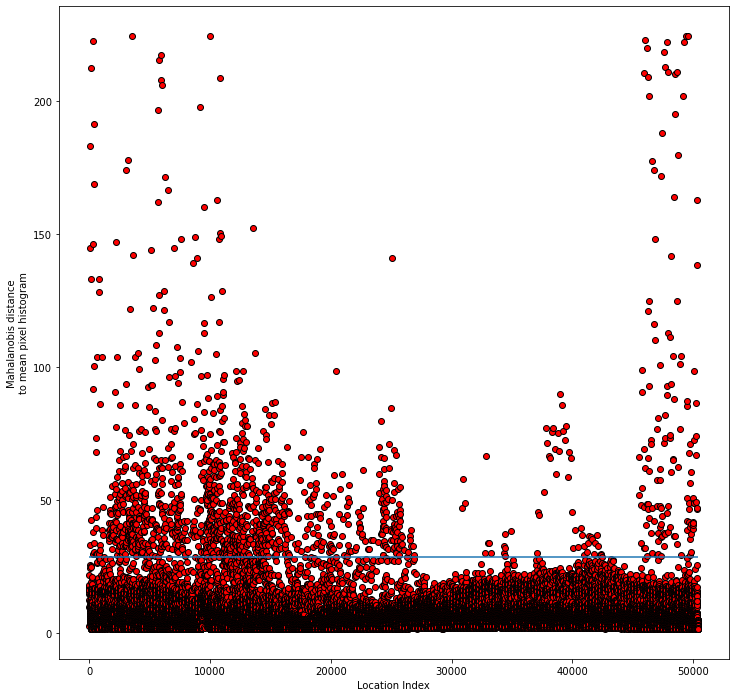

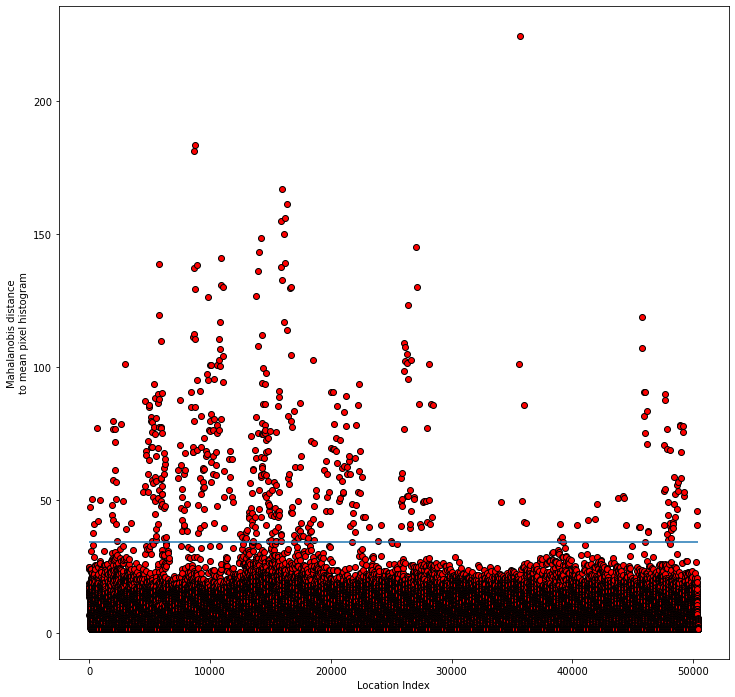

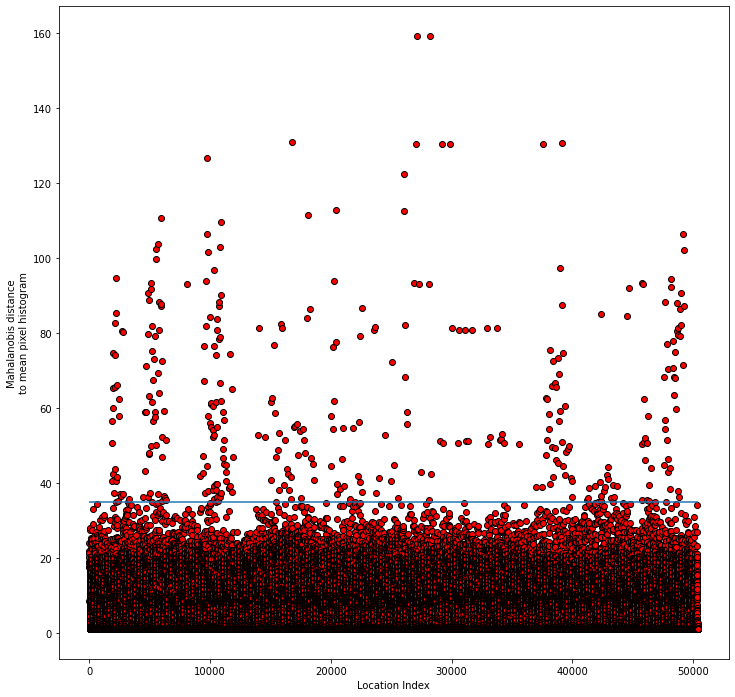

In [ ]:
from scipy.spatial.distance import mahalanobis
def pixel_space_to_mask(pixel_space,threshold_factor= 3):
    mean_array = pixel_space.mean(axis=0)
    std_array = pixel_space.std(axis=0)
    V = np.cov(pixel_space.T)
    IV = np.linalg.pinv(V)
    pixel_distances = []
    for i in pixel_space:
        distance = mahalanobis(mean_array, i,IV)
        pixel_distances.append(distance)
    threshold = np.mean(pixel_distances) + threshold_factor*np.std(pixel_distances)
    valid = pixel_distances < threshold
    tensor_mask = np.array(valid).reshape(420,120)


    plt.figure(figsize=(12,12))
    plt.scatter(np.arange(len(pixel_distances)),pixel_distances,
                color='red',
                edgecolors = 'black')
    plt.hlines(threshold,0,len(pixel_distances))
    plt.xlabel('Location Index')

    plt.ylabel('Mahalanobis distance\nto mean pixel histogram')
    plt.show()
    return tensor_mask

tensor_mask = pixel_space_to_mask(pixel_space,2)
tensor_mask_2 = pixel_space_to_mask(pixel_space_2)
tensor_mask_3 = pixel_space_to_mask(pixel_space_3)

<Figure size 720x576 with 0 Axes>

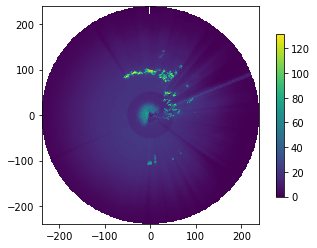

In [ ]:
plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(first_layer.reshape(-1,420,120).mean(axis=0),
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) 
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()


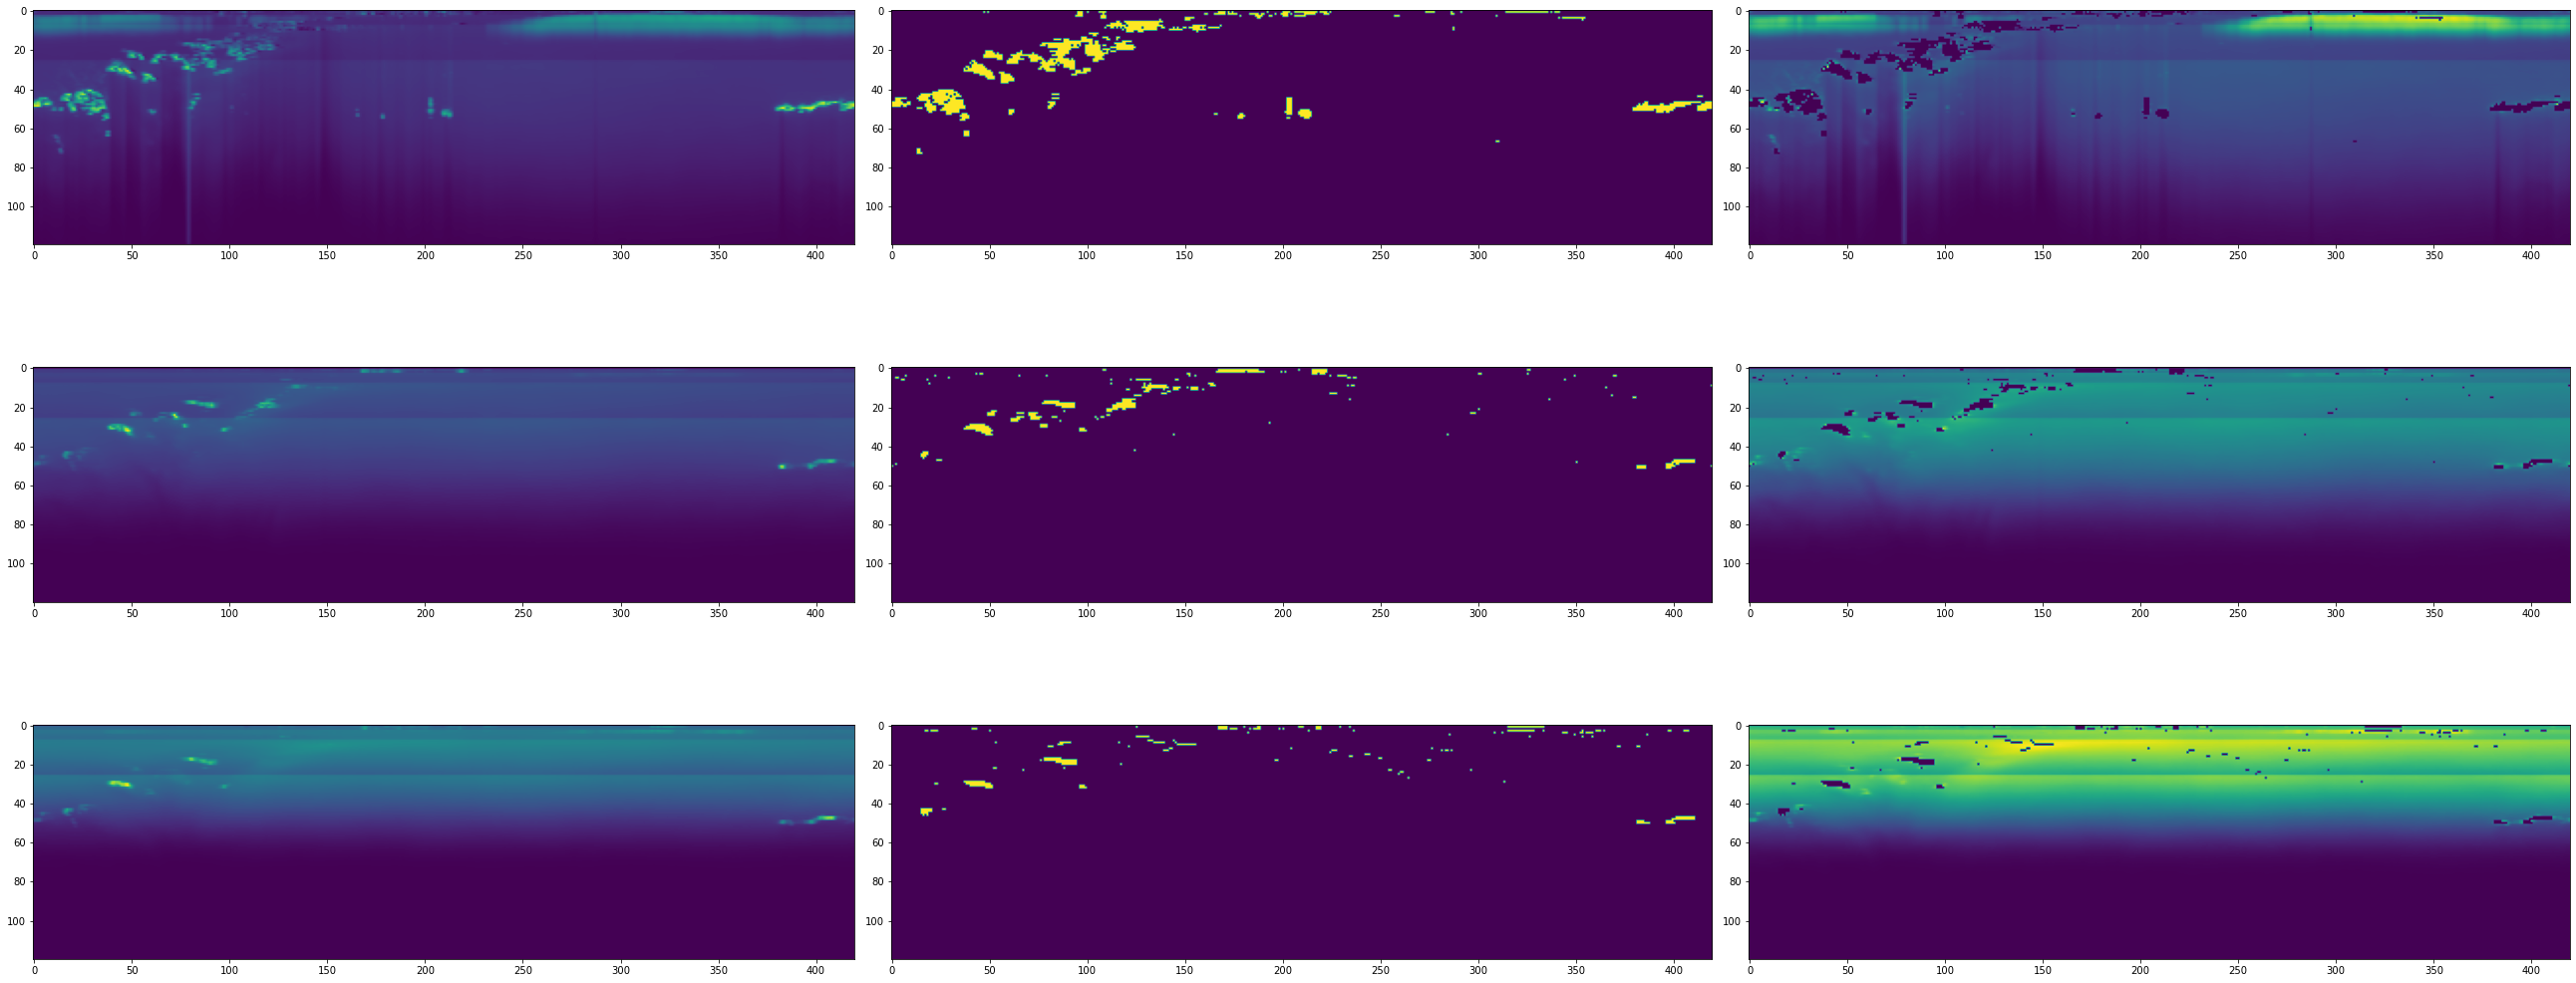

In [ ]:
f,axes = plt.subplots(3,3,figsize=(12*3,16))
axes[0,0].imshow(first_layer.reshape(-1,420,120).mean(axis=0).T)
axes[0,1].imshow(~tensor_mask.T)
axes[0,2].imshow((first_layer.reshape(-1,420,120).mean(axis=0) * tensor_mask).T)

axes[1,0].imshow(second_layer.reshape(-1,420,120).mean(axis=0).T)
axes[1,1].imshow(~tensor_mask_2.T)
axes[1,2].imshow((second_layer.reshape(-1,420,120).mean(axis=0) * tensor_mask_2).T)

axes[2,0].imshow(third_layer.reshape(-1,420,120).mean(axis=0).T)
axes[2,1].imshow(~tensor_mask_3.T)
axes[2,2].imshow((third_layer.reshape(-1,420,120).mean(axis=0) * tensor_mask_3).T)
plt.tight_layout()
plt.show()

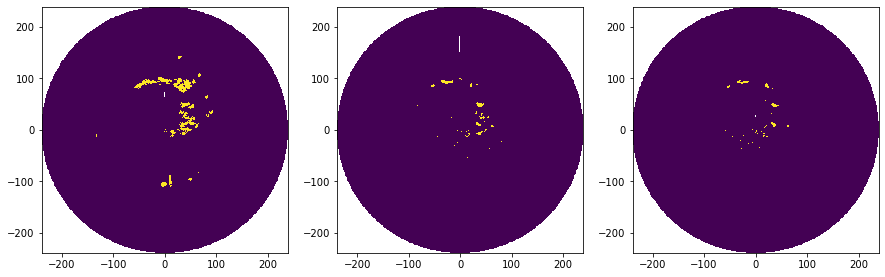

In [ ]:
f,axes = plt.subplots(1,3,figsize=(15,5))
ax, pm = wrl.vis.plot_ppi(~tensor_mask,ax= axes[0],
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
ax, pm = wrl.vis.plot_ppi(~tensor_mask_2,ax= axes[1],
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
ax, pm = wrl.vis.plot_ppi(~tensor_mask_3,ax= axes[2],
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
plt.show()

<Figure size 720x576 with 0 Axes>

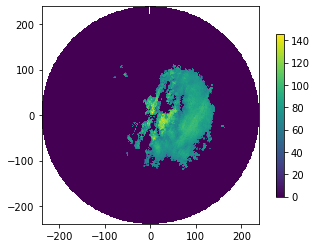

<Figure size 720x576 with 0 Axes>

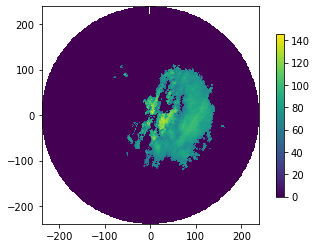

C:\Users\sverrirhd\Anaconda3\envs\gis_wradlib_torch\lib\site-packages\wradlib\trafo.py:262: RuntimeWarning: overflow encountered in power
  return 10.0 ** (x / 10.0)


<Figure size 720x576 with 0 Axes>

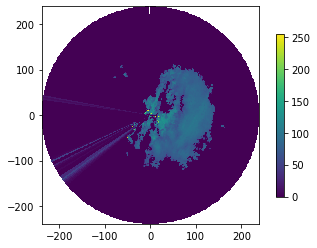

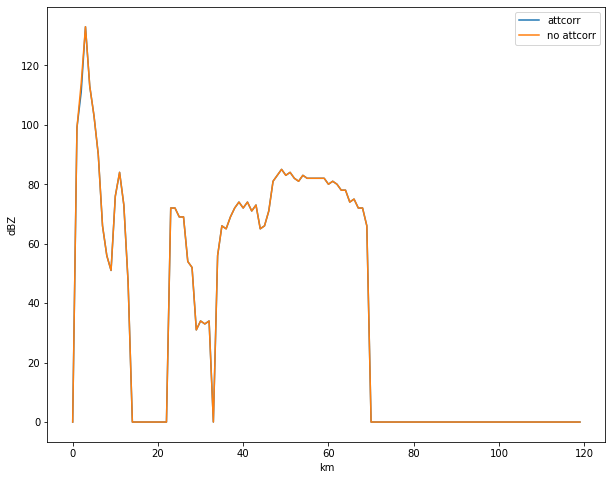

In [ ]:
# data_tmp = first_layer.reshape(-1,420,120)[0]
data_tmp = second_layer.reshape(-1,420,120)[0]
data_no_clutter = wrl.ipol.interpolate_polar(data_tmp, ~tensor_mask)
plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(data_no_clutter,
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()


plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(data_tmp,
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()

pia = wrl.atten.correct_attenuation_constrained(data_no_clutter, a_max=1.67e-4, a_min=2.33e-5,
                                                n_a=100, b_max=0.7, b_min=0.65, n_b=6,
                                                gate_length=2, constraints=[wrl.atten.constraint_dbz,
                                                                             wrl.atten.constraint_pia],
                                                constraint_args=[[59.0],[20.0]])
data_attcorr = data_no_clutter + pia

plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(data_attcorr,
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(data_attcorr[65], label="attcorr")
plt.plot(data_no_clutter[65], label="no attcorr")
plt.xlabel("km")
plt.ylabel("dBZ")
plt.legend()

In [ ]:
gain,offset = (0.5, -32.0)
R,Si = wrl.zr.z_to_r_enhanced(wrl.trafo.idecibel(offset + gain * data_no_clutter))
# R1 = wrl.zr.r_to_z(wrl.trafo.idecibel(offset + gain * data_no_clutter))
depths = wrl.trafo.r_to_depth(R, 300)

In [ ]:
# (R1).max(),(R).max()

<Figure size 720x576 with 0 Axes>

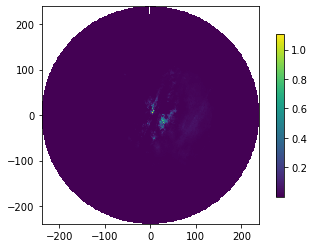

In [ ]:
plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(depths,
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()

In [ ]:
first_layer.shape

(104967, 50400)

In [ ]:
# # Bottom layer
# first_layer_no_clutter = []
# for i,image in enumerate(first_layer.reshape(-1,420,120)):
#     if i % 1000 == 0:
#         print(i,datetime.datetime.now())
#     data_no_clutter = wrl.ipol.interpolate_polar(image, ~tensor_mask)
#     first_layer_no_clutter.append(np.array(data_no_clutter.ravel(),dtype='uint8'))

# first_layer_no_clutter_csc = csc_matrix(first_layer_no_clutter,dtype='uint8')
# save_npz(DIR_data + 'first_layer_2020_no_clutter.npz',first_layer_no_clutter_csc)

# del first_layer_no_clutter_csc
# del first_layer_no_clutter

0 2021-09-28 17:39:25.757080
1000 2021-09-28 17:39:36.122218
2000 2021-09-28 17:39:46.747357
3000 2021-09-28 17:39:57.694017
4000 2021-09-28 17:40:08.646548
5000 2021-09-28 17:40:20.043260
6000 2021-09-28 17:40:32.796822
7000 2021-09-28 17:40:45.243619
8000 2021-09-28 17:40:58.203620
9000 2021-09-28 17:41:10.733357
10000 2021-09-28 17:41:23.927661
11000 2021-09-28 17:41:36.288867
12000 2021-09-28 17:41:49.339299
13000 2021-09-28 17:42:03.041084
14000 2021-09-28 17:42:16.909387
15000 2021-09-28 17:42:30.672415
16000 2021-09-28 17:42:44.470184
17000 2021-09-28 17:42:58.347119
18000 2021-09-28 17:43:12.318501
19000 2021-09-28 17:43:26.855837
20000 2021-09-28 17:43:41.480033
21000 2021-09-28 17:43:56.248128
22000 2021-09-28 17:44:11.371467
23000 2021-09-28 17:44:26.856436
24000 2021-09-28 17:44:42.210604
25000 2021-09-28 17:44:57.618267
26000 2021-09-28 17:45:13.480868
27000 2021-09-28 17:45:29.382145
28000 2021-09-28 17:45:45.468599
29000 2021-09-28 17:46:02.356591
30000 2021-09-28 17:46:

In [ ]:
# # 2nd
# second_layer_no_clutter = []
# for i,image in enumerate(second_layer.reshape(-1,420,120)):
#     if i % 1000 == 0:
#         print(i,datetime.datetime.now())
#     data_no_clutter = wrl.ipol.interpolate_polar(image, ~tensor_mask)
#     second_layer_no_clutter.append(np.array(data_no_clutter.ravel(),dtype='uint8'))

# second_layer_no_clutter_csc = csc_matrix(second_layer_no_clutter,dtype='uint8')
# save_npz(DIR_data + 'second_layer_2020_no_clutter.npz',second_layer_no_clutter_csc)

# del second_layer_no_clutter_csc
# del second_layer_no_clutter

In [ ]:
# # 3rd
# third_layer_no_clutter = []
# for i,image in enumerate(third_layer.reshape(-1,420,120)):
#     if i % 1000 == 0:
#         print(i,datetime.datetime.now())
#     data_no_clutter = wrl.ipol.interpolate_polar(image, ~tensor_mask)
#     third_layer_no_clutter.append(np.array(data_no_clutter.ravel(),dtype='uint8'))

# third_layer_no_clutter_csc = csc_matrix(third_layer_no_clutter,dtype='uint8')
# save_npz(DIR_data + 'third_layer_2020_no_clutter.npz',third_layer_no_clutter_csc)

# del third_layer_no_clutter_csc
# del third_layer_no_clutter

In [9]:
first_layer_no_clutter_csc = load_npz(DIR_data + 'first_layer_2020_no_clutter.npz')
first_layer_no_clutter = first_layer_no_clutter_csc.toarray()
del first_layer_no_clutter_csc

In [10]:
second_layer_no_clutter_csc = load_npz(DIR_data + 'second_layer_2020_no_clutter.npz')
second_layer_no_clutter = second_layer_no_clutter_csc.toarray()
del second_layer_no_clutter_csc

In [11]:
third_layer_no_clutter_csc = load_npz(DIR_data + 'third_layer_2020_no_clutter.npz')
third_layer_no_clutter = third_layer_no_clutter_csc.toarray()
del third_layer_no_clutter_csc

In [14]:
# # Rain gauge metadata
# df_sensors = pd.read_csv(URL_saved_sensor_data, sep='\t', encoding='Windows-1252')
# ## Raw rain gauge data
# rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
# gauges_raw = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T
# gauges_raw = gauges_raw.loc[:,['1473','1475','1481','1485']]
# gauges_raw_hour = gauges_raw.resample('1h').agg(pd.Series.sum, skipna=False)
# # Processed rain gauge data
# gauges_clean_long = pd.read_csv(URL_gauge_data + 'yfirfarid_hbs.csv',sep='\t')
# gauges_clean_long.TIMI = pd.to_datetime(gauges_clean_long.TIMI)
# gauges_clean = gauges_clean_long.pivot_table(values='R',index='TIMI',columns='STOD')
# gauges_clean.columns = [str(i) + '_clean' for i in gauges_clean.columns]
# # All rain gauge data 
# gauges = pd.concat([gauges_raw_hour,gauges_clean],axis=1)

# # Drainage flow data
# df_target = pd.read_pickle('../../Drainage data/all_drainage_data.pkl')

# Check accuracy of this rainfall estimate 

- if it's bad: try to apply radar attenuation (2 types) and check again

In [12]:
def to_depth(data,seconds=300):
    return data/3600*seconds



In [13]:
transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") #

radar_coords

array([[ 72330.78749767, 146416.80747469,   2000.        ],
       [ 73163.78749767, 146416.80747469,   2000.        ],
       [ 73996.78749767, 146416.80747469,   2000.        ],
       ...,
       [571297.78749767, 647049.80747469,   2000.        ],
       [572130.78749767, 647049.80747469,   2000.        ],
       [572963.78749767, 647049.80747469,   2000.        ]])

In [14]:
elangles = [0.5,1.297,2.396,5.0,7.0,10.0,15.0,20.0,]
x = obs_coords[:,0]
y = obs_coords[:,1]
sitecoords_gps = (64.025,-22.636)
sitecoords = transformer_gps_isl.transform(sitecoords_gps[0],sitecoords_gps[1])

In [18]:
import geopandas as gpd
postnr = gpd.read_file('../Radar data analysis/Radar visualization/Shapefiles/postnr/postnrs.shp')

proj = wrl.georef.epsg_to_osr(3057)

polarneighbs = wrl.verify.PolarNeighbours(1. + np.arange(0.,240000.,2000), # Polar
                                          az_angle_bins[:,0] + az_angle_bins[0,1]/2, # Polar
                                          sitecoords_gps[::-1], # GPS
                                          proj, # GPS->ISN93
                                          x, # ISN93
                                          y, # ISN93
                                          nnear=9)

C:\Users\sverrirhd\Anaconda3\envs\gis_wradlib_torch\lib\site-packages\wradlib\georef\polar.py:512: UserWarning: The azimuth angles of the current dataset are not equidistant.
  warnings.warn(


In [106]:
polarneighbs.get_bincoords()

(50400,)

Radar values at rain gauge #0: [55, 0, 30, 0, 0, 0, 0, 0, 0]
Radar values at rain gauge #1: [0, 0, 0, 29, 0, 0, 0, 0, 0]
Radar values at rain gauge #2: [0, 0, 0, 0, 0, 0, 54, 0, 0]
Radar values at rain gauge #3: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Radar values at rain gauge #4: [0, 0, 0, 0, 0, 0, 31, 0, 0]
Radar values at rain gauge #5: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Radar values at rain gauge #6: [0, 44, 31, 0, 0, 34, 0, 62, 0]


<AxesSubplot:title={'center':'Zoom into rain gauge locations'}>

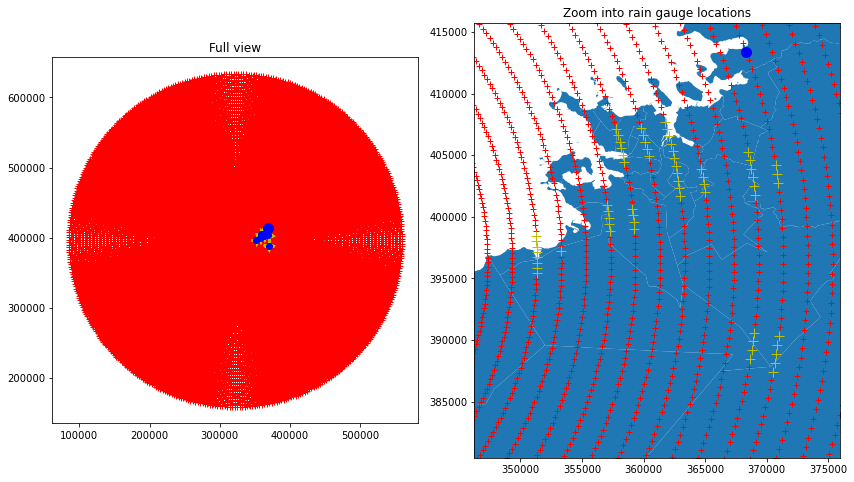

In [118]:


radar_at_gages = polarneighbs.extract(first_layer[10000].reshape(420,120))
for i,gauge in enumerate(radar_at_gages):
    print(f"Radar values at rain gauge #{i}: %r" % gauge.tolist())
    
binx, biny = polarneighbs.get_bincoords()
binx_nn, biny_nn = polarneighbs.get_bincoords_at_points()

x,y = obs_coords[:,0], obs_coords[:,1]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(121)
ax.plot(binx, biny, 'r+')
ax.plot(binx_nn, biny_nn, 'y+', markersize=10)
ax.plot(x, y, 'bo')
test_coordsx,test_coordsy = binx[9265], biny[9265]
ax.plot(test_coordsx,test_coordsy, 'bo', markersize=10)
ax.axis('tight')
ax.set_aspect("equal")
plt.title("Full view")


ax = fig.add_subplot(122)
ax.plot(binx, biny, 'r+')
ax.plot(binx_nn, biny_nn, 'y+', markersize=10)
ax.plot(test_coordsx,test_coordsy, 'bo', markersize=10)
# ax.plot(x, y, 'bo')
scale = 1
plt.xlim(binx_nn.min()-scale*5000, binx_nn.max()+scale*5000)
plt.ylim(biny_nn.min()-scale*7000, biny_nn.max()+scale*8000)
ax.set_aspect("equal")
txt = plt.title("Zoom into rain gauge locations")
plt.tight_layout()
postnr.geometry.plot(ax = ax)


array([268085.78749767, 158911.80747469])

In [20]:
radar_at_gauges = []
for layer in [first_layer_no_clutter,second_layer_no_clutter,third_layer_no_clutter]:
    radar_layer = []
    for radar_slice in layer:
        tmp = polarneighbs.extract(radar_slice.reshape(420,120))
        radar_layer.append(tmp)
    radar_at_gauges.append(radar_layer)

radar_gauge_values = np.array(radar_at_gauges)
radar_gauge_values = np.transpose(radar_gauge_values,(1,2,3,0))

In [21]:
radar_gauge_values.shape

(104967, 7, 9, 3)

In [22]:
new_index = pd.DatetimeIndex(pd.date_range(dates[0],dates[-1],freq='300s'))
gauges_2020 = gauges.loc[new_index,df_sensors.STOD.astype(str)].interpolate()


In [588]:
# for i,gauge in enumerate(gauges_2020.columns):
#     df_radar_neighbours = pd.DataFrame(radar_gauge_values[:,i].reshape(-1,9*3),index = dates).reindex((new_index)).interpolate()
#     series_gauge = gauges_2020.loc[:,gauge]


#     rolling_size = 1
#     rolling_rainfall = to_depth(to_rainfall(df_radar_neighbours)).mean(axis=1).rolling(rolling_size).mean()
#     rolling_raingauge = series_gauge.rolling(rolling_size).mean()
#     corrs = []
#     lags = np.arange(-1000,1000,1)
#     for i in lags:
            
#         rolling_rainfall_shifted = rolling_rainfall.shift(i)
#         corr = rolling_rainfall_shifted.corr(rolling_raingauge)
#         corrs.append(corr)
#         # print()
        
#     plt.plot(lags,corrs)
#     plt.scatter(lags[np.argmax(corrs)],np.max(corrs),c='r')
#     plt.show()
#     print(f'gauge:{gauge} - optimal lag and correlation:',lags[np.argmax(corrs)],np.max(corrs))

# timeseries comaprison with each pixel for each gauge

gauge:1473 - pixel: 0 optimal lag and correlation: -85 0.23434785480388468
gauge:1473 - pixel: 1 optimal lag and correlation: -110 0.23436831179314357
gauge:1473 - pixel: 2 optimal lag and correlation: -85 0.14483367897827032
gauge:1473 - pixel: 3 optimal lag and correlation: -85 0.23029508498220255
gauge:1473 - pixel: 4 optimal lag and correlation: -110 0.23529791849924567
gauge:1473 - pixel: 5 optimal lag and correlation: -110 0.15141743738219107
gauge:1473 - pixel: 6 optimal lag and correlation: -85 0.23434785480388468
gauge:1473 - pixel: 7 optimal lag and correlation: -110 0.23436831179314357
gauge:1473 - pixel: 8 optimal lag and correlation: -85 0.14483367897827032
gauge:1473 - pixel: 9 optimal lag and correlation: -85 0.23029508498220255
gauge:1473 - pixel: 10 optimal lag and correlation: -110 0.23529791849924567
gauge:1473 - pixel: 11 optimal lag and correlation: -110 0.15141743738219107
gauge:1473 - pixel: 12 optimal lag and correlation: -85 0.23434785480388468
gauge:1473 - pix

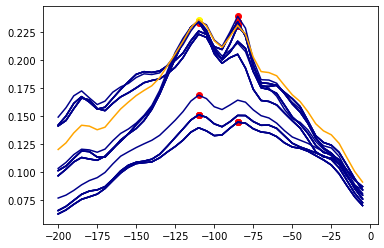

gauge:1474 - pixel: 0 optimal lag and correlation: -90 0.39010408344865083
gauge:1474 - pixel: 1 optimal lag and correlation: -90 0.4427791630669408
gauge:1474 - pixel: 2 optimal lag and correlation: -90 0.40881736056956797
gauge:1474 - pixel: 3 optimal lag and correlation: -90 0.39010408344865083
gauge:1474 - pixel: 4 optimal lag and correlation: -90 0.4427791630669408
gauge:1474 - pixel: 5 optimal lag and correlation: -90 0.40881736056956797
gauge:1474 - pixel: 6 optimal lag and correlation: -90 0.3381707401624024
gauge:1474 - pixel: 7 optimal lag and correlation: -90 0.4334711063278695
gauge:1474 - pixel: 8 optimal lag and correlation: -90 0.41788843778931367
gauge:1474 - pixel: 9 optimal lag and correlation: -90 0.39010408344865083
gauge:1474 - pixel: 10 optimal lag and correlation: -90 0.4427791630669408
gauge:1474 - pixel: 11 optimal lag and correlation: -90 0.40881736056956797
gauge:1474 - pixel: 12 optimal lag and correlation: -90 0.3971783296212046
gauge:1474 - pixel: 13 optim

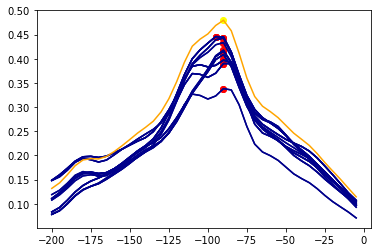

gauge:1475 - pixel: 0 optimal lag and correlation: -90 0.43208057606114336
gauge:1475 - pixel: 1 optimal lag and correlation: -90 0.4457383664884487
gauge:1475 - pixel: 2 optimal lag and correlation: -90 0.4172193417206128
gauge:1475 - pixel: 3 optimal lag and correlation: -90 0.4284960839449828
gauge:1475 - pixel: 4 optimal lag and correlation: -90 0.44330247033478587
gauge:1475 - pixel: 5 optimal lag and correlation: -90 0.41797068079141647
gauge:1475 - pixel: 6 optimal lag and correlation: -90 0.4254989037033262
gauge:1475 - pixel: 7 optimal lag and correlation: -90 0.4406431197629677
gauge:1475 - pixel: 8 optimal lag and correlation: -90 0.42702484818572045
gauge:1475 - pixel: 9 optimal lag and correlation: -90 0.4284960839449828
gauge:1475 - pixel: 10 optimal lag and correlation: -90 0.44330247033478587
gauge:1475 - pixel: 11 optimal lag and correlation: -90 0.41797068079141647
gauge:1475 - pixel: 12 optimal lag and correlation: -90 0.43208057606114336
gauge:1475 - pixel: 13 optim

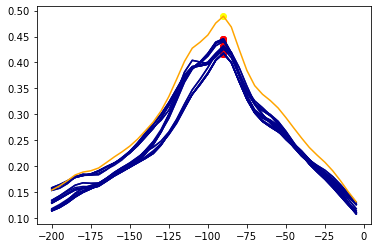

gauge:1478 - pixel: 0 optimal lag and correlation: -85 0.48359887532456947
gauge:1478 - pixel: 1 optimal lag and correlation: -90 0.49045801759234414
gauge:1478 - pixel: 2 optimal lag and correlation: -90 0.4382519321981281
gauge:1478 - pixel: 3 optimal lag and correlation: -85 0.48359887532456947
gauge:1478 - pixel: 4 optimal lag and correlation: -90 0.49045801759234414
gauge:1478 - pixel: 5 optimal lag and correlation: -90 0.4382519321981281
gauge:1478 - pixel: 6 optimal lag and correlation: -85 0.48359887532456947
gauge:1478 - pixel: 7 optimal lag and correlation: -90 0.49045801759234414
gauge:1478 - pixel: 8 optimal lag and correlation: -90 0.4382519321981281
gauge:1478 - pixel: 9 optimal lag and correlation: -90 0.4766456035428197
gauge:1478 - pixel: 10 optimal lag and correlation: -90 0.4721883372613843
gauge:1478 - pixel: 11 optimal lag and correlation: -90 0.4254051576931375
gauge:1478 - pixel: 12 optimal lag and correlation: -85 0.3878875452856255
gauge:1478 - pixel: 13 optima

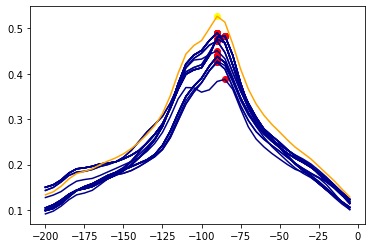

gauge:1481 - pixel: 0 optimal lag and correlation: -90 0.38678145321436036
gauge:1481 - pixel: 1 optimal lag and correlation: -90 0.39728568260334163
gauge:1481 - pixel: 2 optimal lag and correlation: -90 0.30692862056985637
gauge:1481 - pixel: 3 optimal lag and correlation: -90 0.3879107670629142
gauge:1481 - pixel: 4 optimal lag and correlation: -90 0.40008816779984524
gauge:1481 - pixel: 5 optimal lag and correlation: -90 0.30800800636748377
gauge:1481 - pixel: 6 optimal lag and correlation: -90 0.3828807928709866
gauge:1481 - pixel: 7 optimal lag and correlation: -90 0.3946704847374266
gauge:1481 - pixel: 8 optimal lag and correlation: -90 0.3031718192018929
gauge:1481 - pixel: 9 optimal lag and correlation: -90 0.38339936131287145
gauge:1481 - pixel: 10 optimal lag and correlation: -90 0.3984428386886526
gauge:1481 - pixel: 11 optimal lag and correlation: -90 0.30903711816728746
gauge:1481 - pixel: 12 optimal lag and correlation: -90 0.3871149477382261
gauge:1481 - pixel: 13 optim

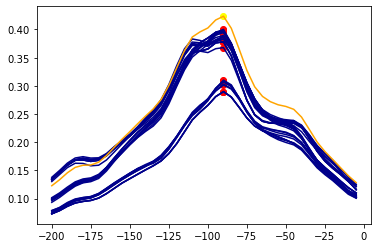

gauge:1482 - pixel: 0 optimal lag and correlation: -110 0.4117956951938967
gauge:1482 - pixel: 1 optimal lag and correlation: -90 0.451853802651289
gauge:1482 - pixel: 2 optimal lag and correlation: -90 0.3970773002123557
gauge:1482 - pixel: 3 optimal lag and correlation: -110 0.4117956951938967
gauge:1482 - pixel: 4 optimal lag and correlation: -90 0.451853802651289
gauge:1482 - pixel: 5 optimal lag and correlation: -90 0.3970773002123557
gauge:1482 - pixel: 6 optimal lag and correlation: -110 0.4117956951938967
gauge:1482 - pixel: 7 optimal lag and correlation: -90 0.451853802651289
gauge:1482 - pixel: 8 optimal lag and correlation: -90 0.3970773002123557
gauge:1482 - pixel: 9 optimal lag and correlation: -110 0.3988906370786887
gauge:1482 - pixel: 10 optimal lag and correlation: -90 0.4479410170028434
gauge:1482 - pixel: 11 optimal lag and correlation: -90 0.3843613499778747
gauge:1482 - pixel: 12 optimal lag and correlation: -110 0.3988906370786887
gauge:1482 - pixel: 13 optimal la

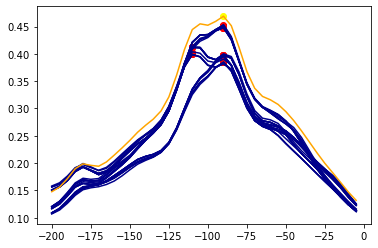

gauge:1485 - pixel: 0 optimal lag and correlation: -90 0.26486553460697254
gauge:1485 - pixel: 1 optimal lag and correlation: -90 0.2712535755147938
gauge:1485 - pixel: 2 optimal lag and correlation: -90 0.24914759279466314
gauge:1485 - pixel: 3 optimal lag and correlation: -90 0.2586435928707922
gauge:1485 - pixel: 4 optimal lag and correlation: -90 0.2641172926319058
gauge:1485 - pixel: 5 optimal lag and correlation: -90 0.24716489107446257
gauge:1485 - pixel: 6 optimal lag and correlation: -90 0.2666061664712792
gauge:1485 - pixel: 7 optimal lag and correlation: -90 0.27420267430239387
gauge:1485 - pixel: 8 optimal lag and correlation: -90 0.24827949559806434
gauge:1485 - pixel: 9 optimal lag and correlation: -90 0.23815529080347733
gauge:1485 - pixel: 10 optimal lag and correlation: -90 0.25794157333275586
gauge:1485 - pixel: 11 optimal lag and correlation: -90 0.24169849015490608
gauge:1485 - pixel: 12 optimal lag and correlation: -90 0.24159328081217318
gauge:1485 - pixel: 13 opt

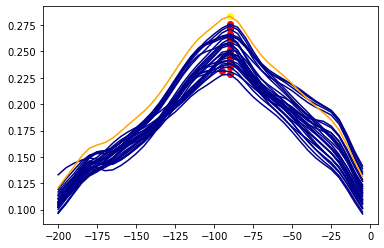

In [23]:
for i,gauge in enumerate(gauges_2020.columns):
    df_radar_neighbours = pd.DataFrame(radar_gauge_values[:,i].reshape(-1,9*3),index = dates).reindex((new_index)).interpolate()
    series_gauge = gauges_2020.loc[:,gauge]


    rolling_size = 60//5
    rolling_rainfall = to_depth(to_rainfall(df_radar_neighbours)).rolling(rolling_size).mean()
    rolling_raingauge = series_gauge.rolling(rolling_size).mean()
    
    for pixel_id in rolling_rainfall.columns:
        corrs = []
        lags = np.arange(-200,0,5)
        for i in lags:
            
            rolling_rainfall_shifted = rolling_rainfall.shift(i).loc[:,pixel_id]
            corr = rolling_rainfall_shifted.corr(rolling_raingauge)
            corrs.append(corr)
        print(f'gauge:{gauge} - pixel: {pixel_id} optimal lag and correlation:',lags[np.argmax(corrs)],np.max(corrs))
        plt.plot(lags,corrs,color='darkblue')
        plt.scatter(lags[np.argmax(corrs)],np.max(corrs),c='r')
        
        
        
    corrs = []
    lags = np.arange(-200,0,5)
    for i in lags:
            
        rolling_rainfall_shifted = rolling_rainfall.shift(i).mean(axis=1)
        corr = rolling_rainfall_shifted.corr(rolling_raingauge)
        corrs.append(corr)
        
    print(f'gauge:{gauge} - average pixel - optimal lag and correlation:',lags[np.argmax(corrs)],np.max(corrs))
    plt.plot(lags,corrs,color='orange')
    plt.scatter(lags[np.argmax(corrs)],np.max(corrs),c='yellow')
    plt.show()
    
    plt.show()
    

# Check for one rain-gauge the global best fit to see if positioning is off

In [47]:
dt_start,dt_end = datetime.datetime(2020,1,1,0,0,0), datetime.datetime(2020,12,31,23,59,59)
new_index_1h = pd.date_range(dt_start,dt_end,freq='1h')
X = gauges_2020.loc[:,'1478'].resample('1h').sum()

In [54]:
print(binx_nn.shape, biny_nn.shape)
binx_nn[3,5], biny_nn[3,5]

(7, 9) (7, 9)


(360265.2077891719, 405481.64449799835)

In [72]:
points_of_interest = polarneighbs.extract(np.arange(420*120).reshape(420,120))

In [76]:
points_of_interest

array([[11895, 12015, 11775, 12135, 11655, 12255, 11535, 12375, 11896],
       [11298, 11418, 11178, 11538, 11299, 11419, 11179, 11539, 11058],
       [ 9979, 10099,  9859, 10219,  9980, 10100,  9739, 10339,  9860],
       [10221, 10101, 10341,  9981, 10461, 10220, 10100,  9861, 10340],
       [10944, 10824, 11064, 10704, 11184, 10945, 10825, 11065, 10584],
       [10821, 10941, 10701, 10822, 10942, 10702, 11061, 10581, 11062],
       [13345, 13225, 13465, 13344, 13224, 13464, 13105, 13585, 13104]])

In [75]:
n_rows = 50000
for point in points_of_interest.ravel():
    Y = pd.DataFrame(second_layer_no_clutter[:,point],index=dates).apply(lambda x : to_rainfall(x).resample('1h').mean())
    corr_list = []
    lag_list = range(-200,200)
    for i in lag_list:
        c = Y.iloc[:,0].shift(i).corr(X)
        corr_list.append(c)
    # plt.plot(lag_list,corr_list)
    # plt.show()
    print(lag_list[np.argmax(corr_list)],np.max(corr_list))

-7 0.35771681223328217
-7 0.3514454087961383
-7 0.35771681223328217
-7 0.3514454087961383
-7 0.35771681223328217
-7 0.3514454087961383
-7 0.35771681223328217
-7 0.3514454087961383
-7 0.3558255236065585
-7 0.3653443381646172
-7 0.3653443381646172
-7 0.37798269093378206
-7 0.3653443381646172
-9 0.378874184369504
-9 0.378874184369504
-9 0.378874184369504
-9 0.378874184369504
-7 0.37798269093378206
-7 0.41974290191505387
-7 0.41734247693846716
-7 0.41008048136871966
-7 0.41734247693846716
-7 0.41974290191505387
-7 0.41734247693846716
-7 0.41008048136871966
-7 0.41734247693846716
-7 0.416399895646461
-7 0.41734247693846716
-7 0.41734247693846716
-7 0.41734247693846716
-8 0.40950317022563404
-9 0.4008955198459749
-7 0.41734247693846716
-7 0.41734247693846716
-8 0.40950317022563404
-7 0.41734247693846716
-8 0.3970671396058104
-8 0.40266477072211226
-8 0.3954400477671551
-8 0.4046022342330132
-8 0.3926736942246546
-8 0.4053605851649133
-8 0.4053605851649133
-8 0.4053605851649133
-8 0.405861849

In [86]:
best_index = -1
best_value = 0

In [127]:
9265%420

25

In [129]:
subset = np.arange(420*120).reshape(420,120)[22-15:22+15,25-15:25+15]

In [134]:
n_test = 1000

points_of_interest = np.random.choice(subset.ravel(),n_test)
for point in points_of_interest.ravel():
    Y = pd.DataFrame(second_layer_no_clutter[:,point],index=dates).apply(lambda x : to_rainfall(x).resample('1h').mean())
    corr_list = []
    lag_list = range(-12,-5)
    for i in lag_list:
        c = Y.iloc[:,0].shift(i).corr(X)
        # print(c)
        corr_list.append(c)
    # plt.plot(lag_list,corr_list)
    # plt.show()
    max_corr = np.max(corr_list)
    max_corr_idx = np.argmax(corr_list)
    # print(lag_list[,max_corr)
    if max_corr > 0.4:
        print(max_corr)
    if max_corr > best_value:
        best_value = max_corr
        best_index = point
        print('New best correlation:',lag_list[max_corr_idx],best_index,best_value)

In [ ]:
# New best correlation: -8 9265 0.43656599776960664 (second layer)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
2020-01-01 00:00:00,110.0,94.0,80.0,99.0,94.0,84.0,110.0,90.0,79.0,107.0,...,77.0,91.0,98.0,88.0,107.0,92.0,78.0,114.0,98.0,92.0
2020-01-01 00:05:00,103.0,108.0,92.0,106.0,108.0,84.0,104.0,101.0,92.0,106.0,...,83.0,114.0,104.0,83.0,105.0,98.0,92.0,114.0,95.0,71.0
2020-01-01 00:10:00,111.0,98.0,94.0,108.0,96.0,84.0,114.0,98.0,95.0,121.0,...,94.0,103.0,91.0,79.0,120.0,98.0,96.0,127.0,98.0,82.0
2020-01-01 00:15:00,105.0,102.0,92.0,112.0,106.0,92.0,110.0,101.0,94.0,122.0,...,110.0,111.0,110.0,90.0,116.0,98.0,93.0,125.0,115.0,97.0
2020-01-01 00:20:00,109.0,106.0,102.0,105.0,104.0,101.0,113.0,110.0,102.0,118.0,...,105.0,102.0,107.0,103.0,117.0,113.0,103.0,118.0,102.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 23:40:00,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,...,0.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 23:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
# rolling_rainfall

In [150]:
shift = -84
rolling_size = 60//5
gauge_name = gauges_2020.columns[3]
rolling_rainfall = to_depth(to_rainfall(df_radar_neighbours)).rolling(rolling_size).mean().shift(shift)
rolling_raingauge = gauges_2020.rolling(rolling_size).mean().loc[:,gauge_name]
print(rolling_rainfall.apply(lambda x : x.corr(rolling_raingauge)).values)

f,axes = plt.subplots(2,1,figsize=(18,12))
rolling_rainfall.mean(axis=1).plot(ax = axes[0])
rolling_raingauge.plot(ax = axes[0])
axes[0].legend(['Radar','Rain gauge'])


rolling_rainfall.mean(axis=1).plot(ax = axes[1])
rolling_raingauge.plot(ax = axes[1])
axes[1].set_xlim(datetime.datetime(2020,5,22),datetime.datetime(2020,6,1))
axes[1].legend(['Radar','Rain gauge'])
plt.show()

[0.34628254 0.38365561 0.34947063 0.35098844 0.38336629 0.34475168
 0.34306224 0.38067715 0.34716334 0.32933266 0.36208302 0.34059563
 0.33083769 0.36750003 0.34561046 0.32498605 0.36126166 0.33874706
 0.32755899 0.37853939 0.34093975 0.33768086 0.3782811  0.34360252
 0.33347409 0.36816756 0.34993551]


KeyboardInterrupt: 

In [546]:
gauges_2020.shape,radar_gauge_values.shape

((105408, 8), (104967, 7, 9))

In [544]:
for i,gauge in enumerate(gauges_2020.columns):
    df_radar_neighbours = pd.DataFrame(radar_gauge_values[:,i].reshape(-1,9),index = dates).reindex((new_index)).interpolate()
    series_gauge = gauges_2020.loc[:,gauge]


    # rolling_size = 1
    # rolling_rainfall = to_depth(to_rainfall(df_radar_neighbours)).rolling(rolling_size).mean()
    # rolling_raingauge = series_gauge.rolling(rolling_size).mean()

    # f,axes = plt.subplots(2,1,figsize=(18,12))
    # rolling_rainfall.mean(axis=1).plot(ax = axes[0])
    # rolling_raingauge.plot(ax = axes[0])
    # axes[0].legend(['Radar','Rain gauge'])

    # rolling_rainfall.mean(axis=1).plot(ax = axes[1])
    # rolling_raingauge.plot(ax = axes[1])
    # axes[1].set_xlim(datetime.datetime(2020,5,22),datetime.datetime(2020,6,1))
    # axes[1].legend(['Radar','Rain gauge'])
    # plt.show()

IndexError: index 7 is out of bounds for axis 1 with size 7

0    1473
1    1474
2    1475
3    1478
4    1481
5    1482
6    1485
Name: STOD, dtype: int64

1473 1473
1473 -95 0.140196913713353
1473 -94 0.13990244780227798
1473 -93 0.14073127843849664
1473 -92 0.14349128974150313
1473 -91 0.14608955014581837
1473 -90 0.14813721615743022
1473 -89 0.15152056463767236
1473 -88 0.15703286137345593
1473 -87 0.1603261381621788
1473 -86 0.16229175519880362
1473 -85 0.16944605669369486
1473 -84 0.17873651572574342
1473 -83 0.18480027900927115
1473 -82 0.18418328553837968
1473 -81 0.17309185122702608
1473 -80 0.1582514600529688
1473 -79 0.1497694025298263
1473 -78 0.14499324575942843
1473 -77 0.13948407073749733
1473 -76 0.1352510177137188


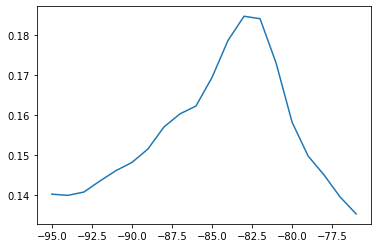

1474 1474
1474 -95 0.29994714897006947
1474 -94 0.3110302135613435
1474 -93 0.3244771596108315
1474 -92 0.34013101233692794
1474 -91 0.3508548469030948
1474 -90 0.34856991802946624
1474 -89 0.3375935638343094
1474 -88 0.32262233741465596
1474 -87 0.3092349626499978
1474 -86 0.3007405960223798
1474 -85 0.2967688101972874
1474 -84 0.29866742956778514
1474 -83 0.3023428850815596
1474 -82 0.3000540053058601
1474 -81 0.28956652848844017
1474 -80 0.27596544405134954
1474 -79 0.26471531970351475
1474 -78 0.25527884010494223
1474 -77 0.245861742184559
1474 -76 0.2355960378243416


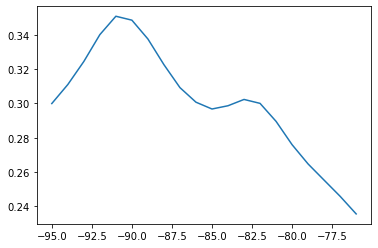

1475 1475
1475 -95 0.288607982968456
1475 -94 0.3003607676492721
1475 -93 0.31383471476522024
1475 -92 0.3251243581243126
1475 -91 0.32869552110015254
1475 -90 0.32347183368569415
1475 -89 0.3130913976365323
1475 -88 0.30307146100612287
1475 -87 0.2946544177904843
1475 -86 0.290447571570136
1475 -85 0.2901571594902992
1475 -84 0.29013214251433034
1475 -83 0.2872730275448603
1475 -82 0.2778452930948787
1475 -81 0.2642050401599021
1475 -80 0.25385427483487655
1475 -79 0.24833838416258489
1475 -78 0.24402376917555846
1475 -77 0.23975345336025605
1475 -76 0.23576327196788624


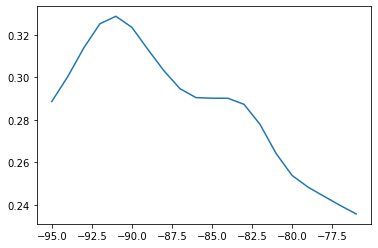

1478 1478
1478 -95 0.2833162734353297
1478 -94 0.29531146821607307
1478 -93 0.3114262301593778
1478 -92 0.3255944170919475
1478 -91 0.3380224507197443
1478 -90 0.3455596057093862
1478 -89 0.34468228095054865
1478 -88 0.33592133479613434
1478 -87 0.3227424341346995
1478 -86 0.31256542554186667
1478 -85 0.3075366014372457
1478 -84 0.3060709291617515
1478 -83 0.3060537982054377
1478 -82 0.3015460944270366
1478 -81 0.2884679624995362
1478 -80 0.2721266088728846
1478 -79 0.26014332732200673
1478 -78 0.2541014338746601
1478 -77 0.24941793332443984
1478 -76 0.24274068757180442


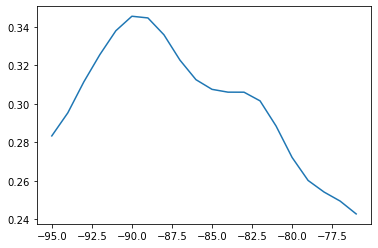

1481 1481
1481 -95 0.24845854931170275
1481 -94 0.2564883639137439
1481 -93 0.2710187903847112
1481 -92 0.288581013693208
1481 -91 0.29560402587425544
1481 -90 0.28842234459151217
1481 -89 0.2739780609058624
1481 -88 0.2598631798020894
1481 -87 0.2488642993554215
1481 -86 0.24037710339212975
1481 -85 0.23556795878218206
1481 -84 0.23314155766924446
1481 -83 0.23227101878842887
1481 -82 0.23402657765312135
1481 -81 0.2331867501499253
1481 -80 0.22923264941568805
1481 -79 0.22710214940088963
1481 -78 0.22184807831137301
1481 -77 0.21065704800394677
1481 -76 0.19861083980120636


KeyboardInterrupt: 

In [176]:
for i,gauge in enumerate(gauges_2020.columns):
    print(df_sensors.STOD.values[i],gauge)
    assert df_sensors.STOD.astype(str).values[i] == gauge
    df_radar_neighbours = pd.DataFrame(radar_gauge_values[:,i].reshape(-1,9*3),index = dates)
    series_gauge = gauges_2020.loc[:,gauge]

    shift = -86
    rolling_size = 1
    
    corrs = []
    lags = range(-95,-75)
    for shift in lags:
        rainfall_tmp = to_depth(to_rainfall(df_radar_neighbours)).sum(axis=1)
        # print(rainfall_tmp)
        rolling_rainfall = rainfall_tmp.reindex((new_index)).interpolate().rolling(rolling_size).mean().shift(shift)
        rolling_raingauge = series_gauge.rolling(rolling_size).mean()
        max_corr = rolling_rainfall.corr(rolling_raingauge)
        corrs.append(max_corr)
        
        print(gauge,shift,max_corr)
    plt.plot(lags,corrs)
    plt.show()
    # f,axes = plt.subplots(2,1,figsize=(18,12))
    # rolling_rainfall.mean(axis=1).plot(ax = axes[0])
    # rolling_raingauge.plot(ax = axes[0])
    # axes[0].legend(['Radar','Rain gauge'])


    # rolling_rainfall.mean(axis=1).plot(ax = axes[1])
    # rolling_raingauge.plot(ax = axes[1])
    # axes[1].set_xlim(datetime.datetime(2020,5,22),datetime.datetime(2020,6,1))
    # axes[1].legend(['Radar','Rain gauge'])
    # plt.show()

In [445]:
# import seaborn as sns
# plt.figure(figsize=(12,12))
# sns.heatmap(pd.concat([gauge_1473,to_depth(to_rainfall(neighbours_1473)).mean(axis=1).shift(-125)],axis=1).corr(),annot=True)

In [590]:
# for i in range(7):
#     gauge_tmp = gauge_1473
#     radar_pixel_tmp = rolling_rainfall.loc[:,i]
    
#     plt.scatter(radar_pixel_tmp,gauge_tmp)
#     plt.title(gauge_tmp.corr(radar_pixel_tmp))
#     plt.show()
# # plt.show()
# # plt.scatter(gauge_1473,to_depth(to_rainfall(neighbours_1473.shift(shift).loc[:,1])))
# # plt.show()

In [591]:
# pd.concat([gauges.loc[good_dates],
#            pd.DataFrame(radar_gauge_values[five_min_interval_gauge].reshape(-1,7*9),index = good_dates)])

In [98]:
radar_coords

array([[ 72330.78749767, 146416.80747469,   2000.        ],
       [ 73163.78749767, 146416.80747469,   2000.        ],
       [ 73996.78749767, 146416.80747469,   2000.        ],
       ...,
       [571297.78749767, 647049.80747469,   2000.        ],
       [572130.78749767, 647049.80747469,   2000.        ],
       [572963.78749767, 647049.80747469,   2000.        ]])

In [339]:
# plt.imshow(first_layer_clfree[:10000].mean(axis=0).T - first_layer[:10000].reshape(-1,420,120).mean(axis=0).T)

In [ ]:
f,axes = plt.subplots(3,1,figsize=(12,12))
axes[0].imshow(first_layer[:10000].reshape(-1,420,120).mean(axis=0).T)
axes[1].imshow(clmap_0.T)
axes[2].imshow(first_layer_clfree[:10000].mean(axis=0).T)
plt.show()

In [ ]:
plt.imshow(radar.values.reshape((-1,40,60)).mean(axis=0))
plt.show()
plt.imshow(first_layer.reshape(-1,420,120).mean(axis=0).T)
plt.imshow(clmap_0.T)
plt.show()
plt.imshow(second_layer.reshape(-1,420,120).mean(axis=0).T)
plt.show()
plt.imshow(third_layer.reshape(-1,420,120).mean(axis=0).T)
plt.show()

In [ ]:
wrl.clutter.filter_gabella(data.mean(axis=0), tr1=12, n_p=6,tr2=1.1)

In [ ]:
# test_idx = 0
start_jan2020 = datetime.datetime(2020,1,1,0,0,0)
end_jan2020 = datetime.datetime(2020,2,1,0,0,0)

max_date = gauges.loc[start_jan2020:end_jan2020].sum(axis=1).idxmax()
max_id = np.argwhere(max_date == dates)[0,0]
# max_id = gauges.sum(axis=1).argmax()

tmp_date = dates[max_id]
tmp_radar = radar[max_id]
tmp_rainfall = to_rainfall(tmp_radar)
tmp_gauges = gauges.loc[max_date]

In [ ]:
gauges

In [ ]:
plt.plot(gauges.loc[:,'1475'].index,gauges.loc[:,'1475'].values)

In [ ]:
gauge_coords = obs_coords[[2],:]
distances_0 = np.sqrt(((radar_coords[:,:2] - gauge_coords)**2).sum(axis=1))
min_index_0 = np.argmin(distances_0)
min_index_0

In [ ]:
# To see if the points are close
tmpx,tmpy = radar_coords[min_index_0,:2]
tmpx1,tmpy1 = obs_coords[2,:]
print(transformer_isl_gps.transform(tmpx,tmpy))
print(transformer_isl_gps.transform(tmpx1,tmpy1))


In [ ]:
closest_pixel = radar.reshape(-1,602**2)[:,min_index_0]
closest_pixel_reflectivity = to_rainfall(closest_pixel)

In [ ]:
plt.plot(gauges.loc[start_jan2020:end_jan2020,'1473'].values)
plt.plot(closest_pixel_reflectivity/4,alpha=0.5)

In [ ]:
plt.hist(gauges.loc[start_jan2020:end_jan2020,'1473'].values)
plt.hist(closest_pixel_reflectivity/2,alpha=0.5)
plt.legend(['Gauge','Radar'])
plt.yscale('log')

In [ ]:
site_coords = np.array((-22.636, 64.025, 0.0))
adjuster = wrl.adjust.AdjustAdd(obs_coords, radar_coords[:,:2])
adjusted_radar = adjuster(tmp_gauges.values,tmp_reflectivity.ravel()).reshape(602,602)

In [ ]:
adjuster = wrl.adjust.AdjustMFB(obs_coords, radar_coords[:,:2])
observed, estimated = adjuster.xvalidate(tmp_gauges.values,tmp_reflectivity.ravel())

from wradlib.verify import ErrorMetrics
metrics = ErrorMetrics(observed, estimated)
metrics.pprint()

In [ ]:
plt.imshow(tmp_radar,vmin=0,vmax=256)
plt.colorbar()
plt.show()

plt.imshow(tmp_rainfall)
plt.colorbar()
plt.show()

In [ ]:
# adjusted = adjuster(obs, radar)